In [6]:
import sys
sys.path.append('../..')

import eeg_decoder
import numpy as np
from collections import OrderedDict
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
experiment_name = 'e'
data_dir = f'./data/{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False,trim_timepoints=[-200,1500])

In [17]:
exp.load_behavior(3);

In [18]:
exp.xdata_files = exp.xdata_files[-3:]
exp.ydata_files = exp.ydata_files[-3:]
exp.artifact_idx_files = exp.artifact_idx_files[-3:]
exp.behavior_files = exp.behavior_files[-3:]
exp.nsub = len(exp.xdata_files)

In [22]:
time_window = 50
time_step = 25
trial_bin_size = 15
n_splits = 30
group_dict = OrderedDict([('SS1',[11,21]),('SS0',[10,20]),('SS2',[12,22])])
train_labels = ['SS1','SS2']
wrangl = eeg_decoder.Wrangler(exp.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict,train_labels=train_labels)
clfr = eeg_decoder.Classification(wrangl,exp.nsub,num_labels=3)

In [23]:
for isub in range(exp.nsub):

    print(isub)
    xdata,ydata = exp.load_eeg(isub)
    xdata,ydata = wrangl.group_labels(xdata,ydata)
    xdata_0,ydata_0 = xdata[ydata==10],ydata[ydata==10]
    xdata, ydata = xdata[ydata!=10],ydata[ydata!=10]

    for X_train_all, X_test_all, y_train, y_test in wrangl.bin_and_split_data(xdata,ydata):

        X_train_all, y_train = wrangl.select_training_data(X_train_all, y_train) 
        X_train_all, y_train = wrangl.balance_labels(X_train_all, y_train)
        X_test_all,y_test = np.concatenate((X_test_all,xdata_0)),np.concatenate((y_test,ydata_0),0)

        y_test_shuffle = np.random.permutation(y_test)

        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):

            clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)
        wrangl.ifold+=1

0
1
2


In [24]:
interp = eeg_decoder.Interpreter(clfr, subtitle='1hvs2_with_1l_1f')
# interp.save_results()

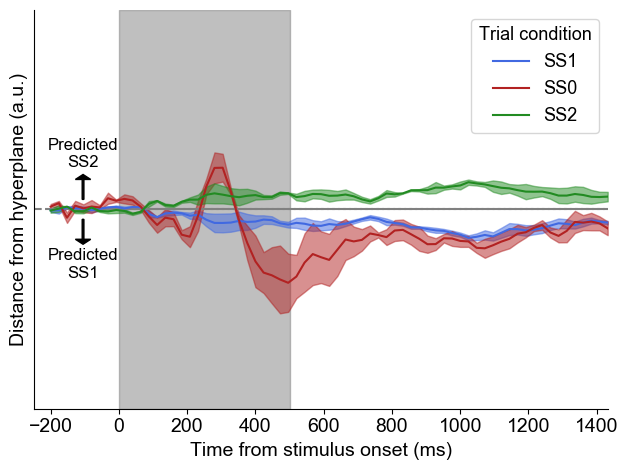

In [25]:
interp.plot_hyperplane(
    stim_time=[0,500],
    ylim=[-10,10],stim_label_xy=[130,3.1],label_text_ys=[-1.95,1.95],arrow_ys=[-.5,.5],
    savefig=False,subtitle='Blank',legend_pos='upper right')

In [7]:
delay_acc =np.mean(np.mean(interp.confidence_scores[:,interp.t>200],2),1)

In [8]:
import pandas as pd
subject_means = pd.DataFrame(delay_acc,columns=list(group_dict.keys()))
labels = list(group_dict.keys())
subject_means['Subject'] = np.arange(exp.nsub)

In [9]:
x = subject_means.melt(id_vars='Subject',value_vars=labels,var_name='Condition',value_name='Distance from Hyperplane')

In [10]:
condition_means = x.groupby('Condition').mean()['Distance from Hyperplane'].to_numpy()

In [11]:
condition_means

array([-1.01554323, -0.67887807, -1.49585681,  1.41989929])

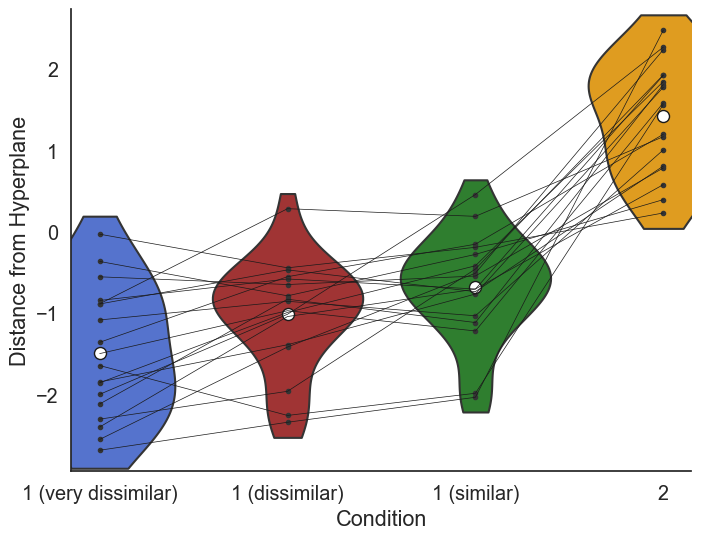

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(font_scale=1.3,style='white',rc=custom_params)

fig,ax = plt.subplots(figsize=(8,6))
sns.violinplot(
    x='Condition',y='Distance from Hyperplane', 
    data=x,ax=ax,palette= interp.colors[:4],
    dodge=True,inner='points',cut=.5,scale='width')
ax.scatter(
    x = [0,1,2,3],
    y = [condition_means[2],condition_means[0],condition_means[1],condition_means[3]],
    c = 'white', edgecolors='k',s=75)

sns.lineplot(
    x='Condition',y='Distance from Hyperplane', units='Subject',
    data=x,ax=ax,palette= interp.colors[:4],estimator=None,
    color='k',linewidth=.5
    )

# plt.savefig('hyperplane_violin.png',dpi=500,bbox_inches='tight')
plt.show()